In [308]:
# Importing necessary Libraries 
import pandas as pd
import pandas_profiling  
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.formula.api as sm

In [2]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(y):
    return pd.Series([y.count(), y.isnull().sum(), y.sum(), y.mean(), y.median(),  y.std(), y.var(), y.min(), y.dropna().quantile(0.01), y.dropna().quantile(0.05),y.dropna().quantile(0.10),y.dropna().quantile(0.25),y.dropna().quantile(0.50),y.dropna().quantile(0.75), y.dropna().quantile(0.90),y.dropna().quantile(0.95), y.dropna().quantile(0.99),y.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

def summary(x):
    num_var=[key for key in dict(x.dtypes) if dict(x.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
    y=x[num_var]
    summary=y.apply(lambda z: var_summary(z)).T
    return summary
    

In [3]:
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
#     col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [4]:
def datedata(df,col):
    df['year'] = df[col].dt.year
    df['month'] = df[col].dt.month
    df['day'] = df[col].dt.day
    df.rename(columns={'year':col+'_year','month':col+'_month','day':col+'_day'},inplace=True)
    df.drop(col,axis=1,inplace=True)
    return df

In [5]:
# Importing Data 
ngo_comclass=pd.read_sas("2. NGO-FUND RAISING ATTRITION- CLASSIFICATION//comclas.sas7bdat",encoding="utf-8")
ngo_commaint=pd.read_sas("2. NGO-FUND RAISING ATTRITION- CLASSIFICATION//commaint.sas7bdat",encoding="utf-8")
ngo_commediu=pd.read_sas("2. NGO-FUND RAISING ATTRITION- CLASSIFICATION//commediu.sas7bdat",encoding="utf-8")
ngo_extrelty=pd.read_sas("2. NGO-FUND RAISING ATTRITION- CLASSIFICATION//extrelty.sas7bdat",encoding="utf-8")
ngo_extrel=pd.read_sas("2. NGO-FUND RAISING ATTRITION- CLASSIFICATION//extrel.sas7bdat",encoding="latin-1")
ngo_nameaddr=pd.read_sas("2. NGO-FUND RAISING ATTRITION- CLASSIFICATION//nameaddr.sas7bdat",encoding="latin-1")
ngo_payhistory=pd.read_sas("2. NGO-FUND RAISING ATTRITION- CLASSIFICATION//payhistory.sas7bdat",encoding="latin-1")
ngo_communication=pd.read_sas("2. NGO-FUND RAISING ATTRITION- CLASSIFICATION//communication.sas7bdat",encoding="latin-1")

In [6]:
# Description of the contact class
# Clascode -> Code of contact class
# Clasdesc ->  Description
ngo_comclass # Only 8 Values

,CLASCODE,CLASDESC
0,CT,CTS-item
1,RI,Request for information
2,CM,Complaint
3,TA,Threath / Accusation
4,AK,Acknowledgement
5,RM,Reminder
6,ID,Information delivery
7,AN,Answer


In [7]:
# Commaint: Description of the main topic code
# Mntopcode -> Main topic code
# Mntopdesc -> Description
ngo_commaint.head() # Only 30 values 

,MNTOPCODE,MNTOPDESC
0,CAN,Cancellations/replacements
1,DIS,Discontinuations
2,MKT,Marketing - Enquiries
3,GEN,General
4,NEW,New relations


In [8]:
# Commediu: Description of Communication Medium type
# Mediumcode -> Code of the mediumtype
# Mediumdesc -> Description
ngo_commediu.head()  # Only 16 Data Point 

,MEDIUMCODE,MEDIUMDESC
0,FF,Face to Face contact
1,FX,Fax
2,TX,Telex
3,EM,Electronic Mail
4,TE,Telephone call


In [9]:
# Communication: All possible communication between the donor and the organization
# Contid     -> Unique identifier for each contact
# Mediumcode -> Medium of the contact (CI is unknown)
# Mntopcode  -> main topic code of the contact
# Classcode  -> Class of the contact
# Extrelno   -> Unique identifier for each donor
# Contdirec  -> Direction of the communication
#                   I ->Incoming
#                   P ->Outgoing
# Contdate   -> Date of the contact
ngo_communication.head()

,CONTID,MEDIUMCODE,MNTOPCODE,CLASCODE,EXTRELNO,CONTDIREC,CONTDATE
0,000405402,CI,CTS,CT,0000020,O,1994-05-09
1,000430904,CI,CTS,CT,0000020,O,1994-06-14
2,000592732,CI,CTS,CT,0000020,O,1994-10-21
3,000593375,CI,CTS,CT,0000020,O,1994-10-21
4,000618514,CI,CTS,CT,0000020,O,1994-11-28


In [10]:
# Extrelno    -> Unique identifier of each donor
# Exrelactcd  -> Activity code of the donor
# Extrelstdt  -> Start date of the relationship
# Exreldaten  -> End date of the relationship (Missing: not ended)
ngo_extrel.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
0,0026414,CT,1995-02-02,NaT
1,0026419,FP,1992-03-01,NaT
2,0026424,FP,1992-03-01,1996-12-24
3,0026430,FP,1992-03-01,2006-01-31
4,0026430,CT,1997-03-07,NaT


In [11]:
# Exrelactcd -> Activity code of the donor
# Exrelactde -> Description of the activity
ngo_extrelty.head()

,EXRELACTCD,EXRELACTDE
0,FP,CommitmentDo
1,PS,Prospect
2,PF,Prosp Fundra
3,PP,Prosp Promot
4,GR,Grantor


In [12]:
# Extrelno     -> Unique identifier of each donor
# Name1title   -> Title to address someone
# Postcode     -> Postcode
# Languagecode -> Preferred mailing language
ngo_nameaddr.head()

,EXTRELNO,NAME1TITLE,POSTCODE,LANGUACODE
0,0000019,HR,2500,NL
1,0000020,HR,9550,NL
2,0000035,HM,2150,NL
3,0000042,FA,3012,NL
4,0000043,MW,3000,NL


In [13]:
# Pid      -> Unique identifier for each payment
# Pdate    -> Date of payment
# Pamt     -> Amount of payment
# ExtrelNo -> Unique identifier of each donor
ngo_payhistory.head()

,PID,PDATE,PAMT,EXTRELNO,PAYTYPECD,STATUS
0,38.0,1993-12-31,9.57,0000019,X,CO
1,39.0,1993-12-31,41.32,0000020,X,CO
2,40.0,1993-12-31,13.10,0000020,X,CO
3,54091.0,1994-01-01,2.02,0000020,X,CO
4,104480.0,1994-05-19,0.50,0000020,D,OK


In [14]:
 # Sorting the Values by 'EXTRELNO' in ascending and 'PDATE' in decending order such that The recent transction is on the Top
ngo_payhistory.sort_values(by=['EXTRELNO', 'PDATE'], ascending=[True,False],inplace=True) 

# Creating Dummy for 'PAYTYPECD' in 'ngo_payhistory'
ngo_payhistory_dummy=create_dummies(ngo_payhistory,'PAYTYPECD')

 # PFREQ is The Frequency of Each 'EXTRELNO' 
PFREQ=ngo_payhistory[['EXTRELNO','PAMT']].groupby(['EXTRELNO']).count() 
 # Renaming The Column of the Groupby Object 
PFREQ.rename(columns={'PAMT':'PFREQ'},inplace=True)    

 # PTOTAMTPAID is Total Amount Donated by Each  'EXTRELNO' 
PTOTAMTPAID=ngo_payhistory[['EXTRELNO','PAMT']].groupby(['EXTRELNO']).sum() 
 # Renaming The Column of the Groupby Object 
PTOTAMTPAID.rename(columns={'PAMT':'PTOTAMTPAID'},inplace=True)

#  Dropping 'PID' -> Unique identifier for each payment                                     
ngo_payhistory.drop(['PID'],axis=1,inplace=True)

 # Keeping only Last Transction Details and drop the Other-> Recency 
ngo_payhistory.drop_duplicates(subset='EXTRELNO',inplace=True)


In [15]:
# Aggregating the number of 'Paytypecd' per 'EXTRELNO':
# 'PAYTYPECD_O' -> O -> Bank transfer
# 'PAYTYPECD_D' -> D -> Permanent order
# 'PAYTYPECD_E' -> E -> Own initiative
# 'PAYTYPECD_X' -> X -> Unknown
p=ngo_payhistory_dummy[['EXTRELNO','PAYTYPECD_D','PAYTYPECD_E','PAYTYPECD_O','PAYTYPECD_X']].groupby(['EXTRELNO']).sum()

# If value of dummy is >= 0 then 1 else 0 
p=p.applymap(lambda x: 1 if x>=1 else 0)

# Sorting Index to avoid non Allignment 
p.sort_index(ascending=True,inplace=True)

In [16]:
# Setting Index of the 'ngo_payhistory' to 'EXTRELNO' to Concatenate with new Variables Formed 
ngo_payhistory.set_index('EXTRELNO',inplace=True)

# Sorting the index to avoid non Allignment 
ngo_payhistory.sort_index(ascending=True,inplace=True)

In [17]:
# Concatenating the 'ngo_payhistory' with New Variables formed and ''PAYTYPECD_O' Dummies 
ngo_payhistory=pd.concat([ngo_payhistory,PFREQ,PTOTAMTPAID,p],axis=1)

In [18]:
ngo_payhistory.head()

,PDATE,PAMT,PAYTYPECD,STATUS,PFREQ,PTOTAMTPAID,PAYTYPECD_D,PAYTYPECD_E,PAYTYPECD_O,PAYTYPECD_X
EXTRELNO,,,,,,,,,,
0000019,1993-12-31,9.57,X,CO,1,9.57,0,0,0,1
0000020,2007-01-17,25.00,D,OK,158,3176.97,1,0,0,1
0000035,2007-01-17,25.00,D,OK,155,3168.40,1,0,0,1
0000042,2001-01-23,-20.33,D,RC,85,1543.03,1,0,0,1
0000043,2003-07-14,23.00,D,OK,229,4373.24,1,0,0,1


In [19]:
# Creating variable -> 'PAVGAMTPAID'= Average Amount Donated by each 'EXTRELNO' = 'PTOTAMTPAID'(Total amount)/'PFREQ'(Total Frequecy)
ngo_payhistory['PAVGAMTPAID'] = ngo_payhistory['PTOTAMTPAID']/ngo_payhistory['PFREQ']

In [20]:
# Sorting values by ''EXTRELNO''
ngo_communication.sort_values(by='EXTRELNO',ascending=True,inplace=True)

In [21]:
# Separating Categorical Variable into other DataFrame " ngo_communication_cat "
ngo_communication_cat=ngo_communication[['MEDIUMCODE', 'MNTOPCODE','CLASCODE','CONTDIREC','EXTRELNO']]

# Creating Dummies of Categorical Variables 
for c_feature in ['MEDIUMCODE', 'MNTOPCODE','CLASCODE','CONTDIREC']:
    ngo_communication_cat[c_feature] = ngo_communication_cat[c_feature].astype('category')
    ngo_communication_cat = create_dummies(ngo_communication_cat , c_feature )

C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [22]:
# a. Separating out Categorical and Numerical Variables to use Groupby Function on Categorical Variables Separately 
cat_list = []
num_list = []
for variable in ngo_communication_cat.columns:
    if ngo_communication_cat[variable].dtype.name in ['object']:
        cat_list.append(variable)
    else:
        num_list.append(variable)

num_list.append('EXTRELNO') # To use this variable in Groupby Object as Unique Donar ID 

In [23]:
# Aggregating 'num_list' values by 'EXTRELNO'
q=ngo_communication_cat[num_list].groupby(['EXTRELNO']).sum()

In [24]:
# There are many communication for a single user so a user may have user a medium of communication more than once so 
# after aggregating the data of a single user there may be values in dummies more than 1 but that does not matter as it would not
# be actegorical thereafter and it would not make sense being continuous variable so wherever value is greater than 1 capping it to 1
q=q.applymap(lambda x: 1 if x>=1 else 0)

In [25]:
# Sorting values first by 'EXTRELNO' and then by  'CONTDATE'
ngo_communication.sort_values(by=['EXTRELNO', 'CONTDATE'], ascending=[True,False],inplace=True)

In [26]:
# Droppping Duplicates wrt to variable 'EXTRELNO'
ngo_communication.drop_duplicates(subset='EXTRELNO',inplace=True)

In [27]:
# Setting 'EXTRELNO' as index of the Dataframe 
ngo_communication.set_index('EXTRELNO',inplace=True)

In [28]:
# Sorting the Dataframe by Index 'EXTRELNO' in ascending order  
ngo_communication.sort_index(ascending=True,inplace=True)

In [29]:
# concatenating categorical dummies with the original dataframe  
ngo_communication=pd.concat([ngo_communication,q],axis=1)

In [30]:
# Dropping the original variables from which dummies were built 
ngo_communication.drop(['MEDIUMCODE','MNTOPCODE','CLASCODE','CONTDIREC','CONTDIREC_O','CONTID'],inplace=True,axis=1)

In [31]:
ngo_communication.head()

,CONTDATE,MEDIUMCODE_AC,MEDIUMCODE_AF,MEDIUMCODE_AM,MEDIUMCODE_CA,MEDIUMCODE_CI,MEDIUMCODE_EM,MEDIUMCODE_FF,MEDIUMCODE_FX,MEDIUMCODE_LE,...,CLASCODE_AK,CLASCODE_AN,CLASCODE_CM,CLASCODE_CT,CLASCODE_ID,CLASCODE_NS,CLASCODE_PM,CLASCODE_RI,CLASCODE_RM,CONTDIREC_I
EXTRELNO,,,,,,,,,,,,,,,,,,,,,
0000020,2006-08-10,0,0,0,0,1,1,0,0,1,...,0,1,0,1,1,0,1,0,0,0
0000035,2006-10-03,0,0,0,0,1,1,0,0,1,...,1,1,0,1,1,0,1,0,0,1
0000042,2001-03-29,0,0,0,0,1,0,0,0,1,...,0,1,0,1,1,0,0,1,1,1
0000043,2004-01-23,0,0,0,0,1,1,0,0,1,...,1,1,0,1,1,0,1,1,0,1
0000060,2000-02-12,0,0,0,0,1,0,0,0,1,...,0,1,0,1,1,0,0,1,0,1


In [32]:
# Subsetting the dataframe 'ngo_extrel' with users that are FP i.e. Active Users 
ngo_extrel_fp=ngo_extrel[ngo_extrel['EXRELACTCD']=='FP']

In [33]:
ngo_extrel_fp.shape

(11442, 4)

In [34]:
ngo_extrel_fp.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
1,0026419,FP,1992-03-01,NaT
2,0026424,FP,1992-03-01,1996-12-24
3,0026430,FP,1992-03-01,2006-01-31
5,0026431,FP,1992-03-01,NaT
7,0026443,FP,1992-03-01,NaT


In [35]:
# Sorting the DataFrame 
ngo_extrel_fp.sort_values(by=['EXTRELNO', 'EXRELDATEN'], ascending=[True,True],inplace=True)

C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
# Droppinng Duplicates by 'EXTRELNO' Column 
ngo_extrel_fp.drop_duplicates(subset='EXTRELNO',inplace=True,keep='last')

C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
# Replacing the values of 'EXRELDATEN' by 0 when NaT and 1 Whenever a Date is present. Doing preparation for Variable "CHURN" .
ngo_extrel_fp['EXRELDATEN']=ngo_extrel_fp['EXRELDATEN'].apply(lambda x: 0 if pd.isnull(x) else 1 )
    

C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
 ngo_extrel_fp.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN
1,0026419,FP,1992-03-01,0
2,0026424,FP,1992-03-01,1
3,0026430,FP,1992-03-01,1
5,0026431,FP,1992-03-01,0
7,0026443,FP,1992-03-01,0


In [39]:
# Setting Index of "ngo_nameaddr" and " ngo_extrel_fp " to  'EXTRELNO' to concate them by this column 
ngo_nameaddr.set_index('EXTRELNO',inplace=True)
ngo_extrel_fp.set_index('EXTRELNO',inplace=True)

In [40]:
# Forming the Combined dataframe from Indivisual Dataframe by Inner join 
ngo=pd.concat([ngo_payhistory,ngo_communication,ngo_extrel_fp,ngo_nameaddr],axis=1,join='inner')

In [41]:
ngo.head()

,PDATE,PAMT,PAYTYPECD,STATUS,PFREQ,PTOTAMTPAID,PAYTYPECD_D,PAYTYPECD_E,PAYTYPECD_O,PAYTYPECD_X,...,CLASCODE_PM,CLASCODE_RI,CLASCODE_RM,CONTDIREC_I,EXRELACTCD,EXTRELSTDT,EXRELDATEN,NAME1TITLE,POSTCODE,LANGUACODE
EXTRELNO,,,,,,,,,,,,,,,,,,,,,
0026419,2007-01-02,75.00,E,OK,69,3155.05,0,1,1,1,...,1,0,0,1,FP,1992-03-01,0,HM,2600,NL
0026424,1997-01-02,20.33,O,OK,35,524.85,0,0,1,1,...,0,0,0,1,FP,1992-03-01,1,MW,1932,NL
0026430,2005-10-18,23.00,D,OK,146,2786.13,1,0,1,1,...,1,1,0,1,FP,1992-03-01,1,HM,2040,NL
0026431,2006-04-28,276.00,E,OK,21,3050.61,0,1,1,1,...,1,0,0,0,FP,1992-03-01,0,FA,8520,NL
0026443,2007-01-17,25.00,D,OK,156,3109.62,1,0,0,1,...,1,1,0,0,FP,1992-03-01,0,HM,1652,NL


In [42]:
ngo.columns

Index(['PDATE', 'PAMT', 'PAYTYPECD', 'STATUS', 'PFREQ', 'PTOTAMTPAID',
       'PAYTYPECD_D', 'PAYTYPECD_E', 'PAYTYPECD_O', 'PAYTYPECD_X',
       'PAVGAMTPAID', 'CONTDATE', 'MEDIUMCODE_AC', 'MEDIUMCODE_AF',
       'MEDIUMCODE_AM', 'MEDIUMCODE_CA', 'MEDIUMCODE_CI', 'MEDIUMCODE_EM',
       'MEDIUMCODE_FF', 'MEDIUMCODE_FX', 'MEDIUMCODE_LE', 'MEDIUMCODE_ME',
       'MEDIUMCODE_MR', 'MEDIUMCODE_NA', 'MEDIUMCODE_RM', 'MEDIUMCODE_TE',
       'MEDIUMCODE_TM', 'MNTOPCODE_ALL', 'MNTOPCODE_ARR', 'MNTOPCODE_CAN',
       'MNTOPCODE_CAT', 'MNTOPCODE_COR', 'MNTOPCODE_CTS', 'MNTOPCODE_DIS',
       'MNTOPCODE_ENR', 'MNTOPCODE_FIC', 'MNTOPCODE_FIN', 'MNTOPCODE_IFF',
       'MNTOPCODE_INF', 'MNTOPCODE_IRE', 'MNTOPCODE_MER', 'MNTOPCODE_PRA',
       'MNTOPCODE_PRO', 'MNTOPCODE_REP', 'MNTOPCODE_SPO', 'MNTOPCODE_TAX',
       'MNTOPCODE_TLT', 'MNTOPCODE_TVS', 'MNTOPCODE_VIS', 'MNTOPCODE_VOL',
       'MNTOPCODE_WEB', 'CLASCODE_AK', 'CLASCODE_AN', 'CLASCODE_CM',
       'CLASCODE_CT', 'CLASCODE_ID', 'CLASCODE_NS'

In [43]:
# Dropping the column which have no variance or does not add any value 
ngo.drop('PAYTYPECD',axis=1,inplace=True)
ngo.drop('EXRELACTCD',axis=1,inplace=True)
ngo.drop('NAME1TITLE',axis=1,inplace=True)
ngo.drop('POSTCODE',axis=1,inplace=True)

In [44]:
# Creating Dummies for the columns that were left unintentionally 
ngo=create_dummies(ngo,'LANGUACODE')
ngo=create_dummies(ngo,'STATUS')

In [45]:
# Getting the Date, Month and Year column from date column because date type columns as they are of no use and can"t be modelled 
ngo=datedata(ngo,'PDATE')
ngo=datedata(ngo,'CONTDATE')
ngo=datedata(ngo,'EXTRELSTDT')

In [46]:
# Renaming column as " CHURN " which is our Y VARIABLE
ngo.rename(columns={'EXRELDATEN':'CHURN'},inplace=True)

In [47]:
# Quick info on the dataframe 
ngo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10780 entries, 0026419 to 0244875
Data columns (total 73 columns):
PAMT                10780 non-null float64
PFREQ               10780 non-null int64
PTOTAMTPAID         10780 non-null float64
PAYTYPECD_D         10780 non-null int64
PAYTYPECD_E         10780 non-null int64
PAYTYPECD_O         10780 non-null int64
PAYTYPECD_X         10780 non-null int64
PAVGAMTPAID         10780 non-null float64
MEDIUMCODE_AC       10780 non-null int64
MEDIUMCODE_AF       10780 non-null int64
MEDIUMCODE_AM       10780 non-null int64
MEDIUMCODE_CA       10780 non-null int64
MEDIUMCODE_CI       10780 non-null int64
MEDIUMCODE_EM       10780 non-null int64
MEDIUMCODE_FF       10780 non-null int64
MEDIUMCODE_FX       10780 non-null int64
MEDIUMCODE_LE       10780 non-null int64
MEDIUMCODE_ME       10780 non-null int64
MEDIUMCODE_MR       10780 non-null int64
MEDIUMCODE_NA       10780 non-null int64
MEDIUMCODE_RM       10780 non-null int64
MEDIUMCODE_TE       1

In [48]:
# Separating Categorical and numerical variable in a list 
ngo_num_var=[key for key in dict(ngo.dtypes) if dict(ngo.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
ngo_cat_var=[key for key in dict(ngo.dtypes) if dict(ngo.dtypes)[key] in ['object']]
print(ngo_num_var)
print(ngo_cat_var)

['PAMT', 'PFREQ', 'PTOTAMTPAID', 'PAYTYPECD_D', 'PAYTYPECD_E', 'PAYTYPECD_O', 'PAYTYPECD_X', 'PAVGAMTPAID', 'MEDIUMCODE_AC', 'MEDIUMCODE_AF', 'MEDIUMCODE_AM', 'MEDIUMCODE_CA', 'MEDIUMCODE_CI', 'MEDIUMCODE_EM', 'MEDIUMCODE_FF', 'MEDIUMCODE_FX', 'MEDIUMCODE_LE', 'MEDIUMCODE_ME', 'MEDIUMCODE_MR', 'MEDIUMCODE_NA', 'MEDIUMCODE_RM', 'MEDIUMCODE_TE', 'MEDIUMCODE_TM', 'MNTOPCODE_ALL', 'MNTOPCODE_ARR', 'MNTOPCODE_CAN', 'MNTOPCODE_CAT', 'MNTOPCODE_COR', 'MNTOPCODE_CTS', 'MNTOPCODE_DIS', 'MNTOPCODE_ENR', 'MNTOPCODE_FIC', 'MNTOPCODE_FIN', 'MNTOPCODE_IFF', 'MNTOPCODE_INF', 'MNTOPCODE_IRE', 'MNTOPCODE_MER', 'MNTOPCODE_PRA', 'MNTOPCODE_PRO', 'MNTOPCODE_REP', 'MNTOPCODE_SPO', 'MNTOPCODE_TAX', 'MNTOPCODE_TLT', 'MNTOPCODE_TVS', 'MNTOPCODE_VIS', 'MNTOPCODE_VOL', 'MNTOPCODE_WEB', 'CLASCODE_AK', 'CLASCODE_AN', 'CLASCODE_CM', 'CLASCODE_CT', 'CLASCODE_ID', 'CLASCODE_NS', 'CLASCODE_PM', 'CLASCODE_RI', 'CLASCODE_RM', 'CONTDIREC_I', 'CHURN', 'PDATE_year', 'PDATE_month', 'PDATE_day', 'CONTDATE_year', 'CONTDATE_m

In [49]:
summary(ngo).head()

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
PAMT,10780.0,0.0,557270.05,51.694810,25.000,81.134072,6.582738e+03,-386.22,-115.000,-20.33,20.330,23.00,25.000,60.9800,138.00,276.0,276.0000,1483.89
PFREQ,10780.0,0.0,735781.00,68.254267,53.000,59.001278,3.481151e+03,1.00,1.000,4.00,8.900,21.00,53.000,109.0000,153.00,156.0,216.2100,1510.00
PTOTAMTPAID,10780.0,0.0,19425885.99,1802.030240,1768.575,1253.348160,1.570882e+06,-875.00,7.455,121.98,276.936,777.03,1768.575,2925.9025,3111.29,3129.6,5334.6971,30860.49
PAYTYPECD_D,10780.0,0.0,7336.00,0.680519,1.000,0.466297,2.174329e-01,0.00,0.000,0.00,0.000,0.00,1.000,1.0000,1.00,1.0,1.0000,1.00
PAYTYPECD_E,10780.0,0.0,2920.00,0.270872,0.000,0.444431,1.975187e-01,0.00,0.000,0.00,0.000,0.00,0.000,1.0000,1.00,1.0,1.0000,1.00


In [50]:
# Clipping outlier 
ngo['PAMT']=ngo['PAMT'].clip_upper(ngo['PAMT'].quantile(0.99)) 
ngo['PAMT']=ngo['PAMT'].clip_lower(ngo['PAMT'].quantile(0.01)) 
ngo['PFREQ']=ngo['PFREQ'].clip_upper(ngo['PFREQ'].quantile(0.99)) 
ngo['PFREQ']=ngo['PFREQ'].clip_lower(ngo['PFREQ'].quantile(0.01)) 
ngo['PTOTAMTPAID']=ngo['PTOTAMTPAID'].clip_upper(ngo['PTOTAMTPAID'].quantile(0.99)) 
ngo['PTOTAMTPAID']=ngo['PTOTAMTPAID'].clip_lower(ngo['PTOTAMTPAID'].quantile(0.01)) 
ngo['PAVGAMTPAID']=ngo['PAVGAMTPAID'].clip_upper(ngo['PAVGAMTPAID'].quantile(0.99)) 
ngo['PAVGAMTPAID']=ngo['PAVGAMTPAID'].clip_lower(ngo['PAVGAMTPAID'].quantile(0.01)) 


In [187]:
#Splitting the data for Random Forest to do variable Seletion 

feature_columns_f = ngo.columns.difference( ['CHURN'] )

In [188]:
from sklearn.cross_validation import train_test_split
# Splitting the Training and testig data 
train_X, test_X, train_y, test_y = train_test_split( ngo[feature_columns_f],
                                                  ngo['CHURN'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

In [189]:
# Building the Random Forest Classifier and fitting the model on the data 
radm_clf_f = RandomForestClassifier(oob_score=True,n_estimators=100 )
radm_clf_f.fit( train_X, train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [190]:
# Prediting with Random Forest 
radm_test_pred_f = pd.DataFrame( { 'actual':  test_y,
                            'predicted': radm_clf_f.predict( test_X ) } )

In [191]:
# Getting accuracy from Random Forest 
from sklearn import metrics
metrics.accuracy_score( radm_test_pred_f.actual, radm_test_pred_f.predicted )

0.9948979591836735

AttributeError: module 'matplotlib' has no attribute 'ylabel'

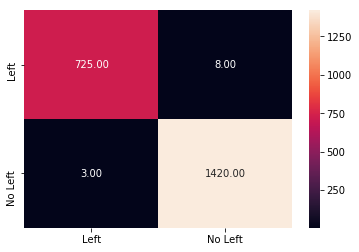

In [192]:
# Getting Confusion matrix and plotting it. 
tree_cm = metrics.confusion_matrix( radm_test_pred_f.predicted,
                                 radm_test_pred_f.actual,
                                 [1,0] )
sn.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')


In [193]:
# Indices for feature importance 
indices = np.argsort(radm_clf_f.feature_importances_)[::-1]

In [203]:
# Getting Feature Importance g
feature_rank_f = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
 
for f in range(train_X.shape[1]):
    feature_rank_f.loc[f] = [f+1,
                          train_X.columns[indices[f]],
                          radm_clf_f.feature_importances_[indices[f]]]

# Use the down code to Plot feature Importance but not here because feature number is very Large
# sn.barplot( y = 'feature', x = 'importance', data = feature_rank )

In [206]:
# Selecting first 15 features for Further FEature Selction 
feature_rank_f.head(15)

,rank,feature,importance
0,1,MNTOPCODE_DIS,0.241358
1,2,PDATE_year,0.213723
2,3,CONTDATE_year,0.136412
3,4,PDATE_month,0.076168
4,5,PAMT,0.056485
5,6,CLASCODE_PM,0.026878
6,7,CONTDATE_month,0.023256
7,8,PAVGAMTPAID,0.022771
8,9,PTOTAMTPAID,0.021483
9,10,EXTRELSTDT_year,0.019174


In [205]:
# Getting Commulative Sum of feature Importance  
for i in range(1,15):
    print(str(i)+str("  ")+str(feature_rank_f.importance[0:i].sum()*100))

1  24.1358282582625
2  45.50810826802961
3  59.1493305687392
4  66.76610355535615
5  72.41459720682609
6  75.10243424319984
7  77.42803083707796
8  79.70517773525407
9  81.8534736439071
10  83.77087927917344
11  85.58005445953654
12  87.25908629585
13  88.79361240908786
14  90.08837014032423


In [73]:
# Adding selected feature name to list 
var = []
for i in range(0,15):
    var.append(feature_rank_f.feature[i])

In [74]:
# Building a new DataFrame With Selected Features to do further feature selection 
ngo_select_0=ngo[var]

In [76]:
ngo_select_0.head()

,MNTOPCODE_DIS,PDATE_year,CONTDATE_year,PAMT,PDATE_month,CONTDATE_month,MEDIUMCODE_EM,PAVGAMTPAID,EXTRELSTDT_year,PTOTAMTPAID,CLASCODE_PM,PDATE_day,PAYTYPECD_E,MEDIUMCODE_RM,PFREQ
EXTRELNO,,,,,,,,,,,,,,,
0026419,0,2007,2006,75.00,1,7,1,45.725362,1992,3155.05,1,2,1,1,69.0
0026424,1,1997,1997,20.33,1,6,0,14.995714,1992,524.85,0,2,0,0,35.0
0026430,1,2005,2006,23.00,10,3,1,19.083082,1992,2786.13,1,18,0,1,146.0
0026431,0,2006,2006,276.00,4,10,1,145.267143,1992,3050.61,1,28,1,1,21.0
0026443,0,2007,2006,25.00,1,12,1,19.933462,1992,3109.62,1,17,0,1,156.0


In [78]:
# I have chosen the column by Hand here so there may be a difference in the last one variable taken here and got in feature_f table
cont=['PDATE_year','CONTDATE_year','PDATE_month','CONTDATE_month','PTOTAMTPAID','PAVGAMTPAID','EXTRELSTDT_year','PDATE_day','PFREQ','PAMT']
disc=['MNTOPCODE_DIS','CLASCODE_PM','PAYTYPECD_E','MEDIUMCODE_EM','MEDIUMCODE_RM']
ngo_select_0_cont=ngo_select_0[cont]
ngo_select_0_disc=ngo_select_0[disc]

In [79]:
# transformations = X, X_squared, X_sqrt, X_ln
squared = (ngo_select_0_cont**2).add_suffix("_squared")
square_root = (ngo_select_0_cont**0.5).add_suffix("_sqrt")
# natural_log = np.log(ngo_select_0_cont+1).add_suffix("_ln")  Can't Take Log Due to Negative Values
ngo_select_0_cont = pd.concat([ngo_select_0_cont, squared, square_root], axis=1)
ngo_select_0_cont.head()

,PDATE_year,CONTDATE_year,PDATE_month,CONTDATE_month,PTOTAMTPAID,PAVGAMTPAID,EXTRELSTDT_year,PDATE_day,PFREQ,PAMT,...,PDATE_year_sqrt,CONTDATE_year_sqrt,PDATE_month_sqrt,CONTDATE_month_sqrt,PTOTAMTPAID_sqrt,PAVGAMTPAID_sqrt,EXTRELSTDT_year_sqrt,PDATE_day_sqrt,PFREQ_sqrt,PAMT_sqrt
EXTRELNO,,,,,,,,,,,,,,,,,,,,,
0026419,2007,2006,1,7,3155.05,45.725362,1992,2,69.0,75.00,...,44.799554,44.788391,1.000000,2.645751,56.169832,6.762053,44.631827,1.414214,8.306624,8.660254
0026424,1997,1997,1,6,524.85,14.995714,1992,2,35.0,20.33,...,44.687806,44.687806,1.000000,2.449490,22.909605,3.872430,44.631827,1.414214,5.916080,4.508880
0026430,2005,2006,10,3,2786.13,19.083082,1992,18,146.0,23.00,...,44.777226,44.788391,3.162278,1.732051,52.783804,4.368419,44.631827,4.242641,12.083046,4.795832
0026431,2006,2006,4,10,3050.61,145.267143,1992,28,21.0,276.00,...,44.788391,44.788391,2.000000,3.162278,55.232327,12.052682,44.631827,5.291503,4.582576,16.613248
0026443,2007,2006,1,12,3109.62,19.933462,1992,17,156.0,25.00,...,44.799554,44.788391,1.000000,3.464102,55.763967,4.464691,44.631827,4.123106,12.489996,5.000000


In [81]:
# Adding the the selected variable with their transformation in the list for further feature Generation 
ngo_select_0_cont_var= []
for variable in ngo_select_0_cont.columns:
     ngo_select_0_cont_var.append(variable)


In [82]:
# Feature Generation by Taking every pair of numerical variable availabe and making variable by adding, subtracting,multiplying and dividing values 
for variablei in ngo_select_0_cont_var:
    for variablej in ngo_select_0_cont_var:
        ngo_select_0_cont['variableivariablej']= ngo_select_0_cont[variablei]+ ngo_select_0_cont[variablej]
        ngo_select_0_cont.rename(columns={'variableivariablej':variablei+"+"+variablej},inplace=True)
        ngo_select_0_cont['variableivariablej']= ngo_select_0_cont[variablei]- ngo_select_0_cont[variablej]
        ngo_select_0_cont.rename(columns={'variableivariablej':variablei+"-"+variablej},inplace=True)
        ngo_select_0_cont['variableivariablej']= ngo_select_0_cont[variablei]* ngo_select_0_cont[variablej]
        ngo_select_0_cont.rename(columns={'variableivariablej':variablei+"*"+variablej},inplace=True)
        ngo_select_0_cont['variableivariablej']= ngo_select_0_cont[variablei]/ ngo_select_0_cont[variablej]
        ngo_select_0_cont.rename(columns={'variableivariablej':variablei+"/"+variablej},inplace=True)
             

In [83]:
ngo_select_0_cont.head()

,PDATE_year,CONTDATE_year,PDATE_month,CONTDATE_month,PTOTAMTPAID,PAVGAMTPAID,EXTRELSTDT_year,PDATE_day,PFREQ,PAMT,...,PAMT_sqrt*PDATE_day_sqrt,PAMT_sqrt/PDATE_day_sqrt,PAMT_sqrt+PFREQ_sqrt,PAMT_sqrt-PFREQ_sqrt,PAMT_sqrt*PFREQ_sqrt,PAMT_sqrt/PFREQ_sqrt,PAMT_sqrt+PAMT_sqrt,PAMT_sqrt-PAMT_sqrt,PAMT_sqrt*PAMT_sqrt,PAMT_sqrt/PAMT_sqrt
EXTRELNO,,,,,,,,,,,,,,,,,,,,,
0026419,2007,2006,1,7,3155.05,45.725362,1992,2,69.0,75.00,...,12.247449,6.123724,16.966878,0.353630,71.937473,1.042572,17.320508,0.0,75.00,1.0
0026424,1997,1997,1,6,524.85,14.995714,1992,2,35.0,20.33,...,6.376519,3.188260,10.424960,-1.407200,26.674895,0.762140,9.017760,0.0,20.33,1.0
0026430,2005,2006,10,3,2786.13,19.083082,1992,18,146.0,23.00,...,20.346990,1.130388,16.878877,-7.287214,57.948253,0.396906,9.591663,0.0,23.00,1.0
0026431,2006,2006,4,10,3050.61,145.267143,1992,28,21.0,276.00,...,87.909044,3.139609,21.195823,12.030672,76.131465,3.625308,33.226495,0.0,276.00,1.0
0026443,2007,2006,1,12,3109.62,19.933462,1992,17,156.0,25.00,...,20.615528,1.212678,17.489996,-7.489996,62.449980,0.400320,10.000000,0.0,25.00,1.0


In [84]:
ngo_select_0_cont.get_dtype_counts()

float64    3186
int64       444
dtype: int64

In [437]:
# Adding categorcal variable to list 
ngo_select_0_disc_var= []
for variable in ngo_select_0_disc.columns:
      ngo_select_0_disc_var.append(variable)


In [85]:
# Concatenating the Discrete and Continous new formed Variable 
ngo1=pd.concat([ngo_select_0_cont,ngo_select_0_disc],axis=1)

In [86]:
ngo1.head()

,PDATE_year,CONTDATE_year,PDATE_month,CONTDATE_month,PTOTAMTPAID,PAVGAMTPAID,EXTRELSTDT_year,PDATE_day,PFREQ,PAMT,...,PAMT_sqrt/PFREQ_sqrt,PAMT_sqrt+PAMT_sqrt,PAMT_sqrt-PAMT_sqrt,PAMT_sqrt*PAMT_sqrt,PAMT_sqrt/PAMT_sqrt,MNTOPCODE_DIS,CLASCODE_PM,PAYTYPECD_E,MEDIUMCODE_EM,MEDIUMCODE_RM
EXTRELNO,,,,,,,,,,,,,,,,,,,,,
0026419,2007,2006,1,7,3155.05,45.725362,1992,2,69.0,75.00,...,1.042572,17.320508,0.0,75.00,1.0,0,1,1,1,1
0026424,1997,1997,1,6,524.85,14.995714,1992,2,35.0,20.33,...,0.762140,9.017760,0.0,20.33,1.0,1,0,0,0,0
0026430,2005,2006,10,3,2786.13,19.083082,1992,18,146.0,23.00,...,0.396906,9.591663,0.0,23.00,1.0,1,1,0,1,1
0026431,2006,2006,4,10,3050.61,145.267143,1992,28,21.0,276.00,...,3.625308,33.226495,0.0,276.00,1.0,0,1,1,1,1
0026443,2007,2006,1,12,3109.62,19.933462,1992,17,156.0,25.00,...,0.400320,10.000000,0.0,25.00,1.0,0,1,0,1,1


In [ ]:
# Handling missing values due to square root of negative values
miss=ngo1.isna().sum()
miss1=miss[miss.values>0]
misslist=[]
for variable in miss1.index:
    misslist.append(variable)

In [ ]:
# Filling missing values by mean 
for variable in misslist:
    ngo1[variable]=ngo1[variable].fillna(ngo1[variable].mean())

In [ ]:
#Handling Outliers -->> May not be needed here
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

ngo1=ngo1.apply(lambda x: outlier_capping(x))

In [ ]:
# Checking for Infinite columns 
fin=np.isinf(ngo1).sum()
fin1=fin[fin.values>0]
fin1.head()

In [ ]:
# Adding all infinite column names to 'inf_var' variable.
inf_var=[]
for variable in fin1.index:
    inf_var.append(variable)

# Dropping the infinite Columns 
ngo1.drop(inf_var,axis=1,inplace=True)

In [165]:
#Splitting the data into Train and Testing 
feature_columns = ngo1.columns

train_X, test_X, train_y, test_y = train_test_split( ngo1[feature_columns],
                                                  ngo['CHURN'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

In [177]:
# Building Random Forest with 300 Trees 
radm_clf = RandomForestClassifier(oob_score=True,n_estimators=300 )
radm_clf.fit( train_X, train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [178]:
# Predicting with Random Forest 
radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': radm_clf.predict( test_X ) } )

In [179]:
# Getting Accuracy Score from the Random Forest
from sklearn import metrics
metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted )

0.9902597402597403

AttributeError: module 'matplotlib' has no attribute 'ylabel'

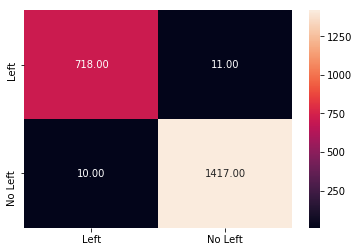

In [180]:
# Confusion Matrix for New Random Forest Model. Seems there's not much improvement in model with so many features 
tree_cm = metrics.confusion_matrix( radm_test_pred.predicted,
                                 radm_test_pred.actual,
                                 [1,0] )
sn.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')


In [182]:
# Getting indices for FEature Importance 
indices = np.argsort(radm_clf.feature_importances_)[::-1]

In [183]:
# Getting feature importance DataFrame  
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
 
for f in range(train_X.shape[1]):
    feature_rank.loc[f] = [f+1,
                          train_X.columns[indices[f]],
                          radm_clf.feature_importances_[indices[f]]]

# Use the down code to Plot feature Importance but not here because feature number is very Large
# sn.barplot( y = 'feature', x = 'importance', data = feature_rank )

In [184]:
# FEature importnce is not good wrt to what we got earlier 
feature_rank.head(15)

,rank,feature,importance
0,1,PDATE_year_squared-PAMT_sqrt,0.020366
1,2,PAMT_sqrt-PDATE_year_squared,0.020121
2,3,PDATE_year_squared+CONTDATE_month,0.019732
3,4,PAMT_sqrt+PDATE_year_squared,0.017845
4,5,PDATE_year_squared+PDATE_month_squared,0.017830
5,6,PAMT-PDATE_year_squared,0.017069
6,7,CONTDATE_month_squared+PDATE_year_squared,0.016979
7,8,PDATE_year_squared+CONTDATE_month_sqrt,0.016928
8,9,PAVGAMTPAID+PDATE_year_squared,0.015673
9,10,PDATE_year_squared+PAVGAMTPAID,0.015372


In [185]:
# Cummulative sum of Feature Importance 
for i in range(1,15):
    print(str(i)+str("  ")+str(feature_rank.importance[0:i].sum()*100))

1  2.036646371242627
2  4.048711553503821
3  6.021871817416725
4  7.806369323781906
5  9.589328461649513
6  11.296193908435564
7  12.994133395041352
8  14.686914598335976
9  16.254208456083894
10  17.79140833358215
11  19.27723988151816
12  20.678002271548028
13  22.07497794475409
14  23.47099536452227


# Nothing Much useful got by these transformations but one doubt here why I did'nt got earlier variables which were good , So now comming back to variables from Firsr Random Forest Model

In [186]:
ngo_select_0.head()

,MNTOPCODE_DIS,PDATE_year,CONTDATE_year,PAMT,PDATE_month,CONTDATE_month,MEDIUMCODE_EM,PAVGAMTPAID,EXTRELSTDT_year,PTOTAMTPAID,CLASCODE_PM,PDATE_day,PAYTYPECD_E,MEDIUMCODE_RM,PFREQ
EXTRELNO,,,,,,,,,,,,,,,
0026419,0,2007,2006,75.00,1,7,1,45.725362,1992,3155.05,1,2,1,1,69.0
0026424,1,1997,1997,20.33,1,6,0,14.995714,1992,524.85,0,2,0,0,35.0
0026430,1,2005,2006,23.00,10,3,1,19.083082,1992,2786.13,1,18,0,1,146.0
0026431,0,2006,2006,276.00,4,10,1,145.267143,1992,3050.61,1,28,1,1,21.0
0026443,0,2007,2006,25.00,1,12,1,19.933462,1992,3109.62,1,17,0,1,156.0


# Comming Back to the Feature Importance We got from Earlier Linear Regression 

In [209]:
# Feature Importance from Earlier Random Forest   
feature_rank_f.head(20)

,rank,feature,importance
0,1,MNTOPCODE_DIS,0.241358
1,2,PDATE_year,0.213723
2,3,CONTDATE_year,0.136412
3,4,PDATE_month,0.076168
4,5,PAMT,0.056485
5,6,CLASCODE_PM,0.026878
6,7,CONTDATE_month,0.023256
7,8,PAVGAMTPAID,0.022771
8,9,PTOTAMTPAID,0.021483
9,10,EXTRELSTDT_year,0.019174


In [211]:
# Selecting Top 20 Feature for New Model with cummulative of 95% Importance 
for i in range(1,20):
    print(str(i)+str("  ")+str(feature_rank_f.importance[0:i].sum()*100))

1  24.1358282582625
2  45.50810826802961
3  59.1493305687392
4  66.76610355535615
5  72.41459720682609
6  75.10243424319984
7  77.42803083707796
8  79.70517773525407
9  81.8534736439071
10  83.77087927917344
11  85.58005445953654
12  87.25908629585
13  88.79361240908786
14  90.08837014032423
15  91.3182925624887
16  92.47082449131766
17  93.44458715160182
18  94.24680539425017
19  94.99777826723205


In [214]:
# Adding Feature Importance variable to list 
var_log = []
for i in range(0,15):
    var_log.append(feature_rank_f.feature[i])

In [216]:
# Sebsetting The selected variables to New DataFrame 
ngo_select_logistic=ngo[var_log]

In [217]:
ngo_select_logistic.head()

,MNTOPCODE_DIS,PDATE_year,CONTDATE_year,PDATE_month,PAMT,CLASCODE_PM,CONTDATE_month,PAVGAMTPAID,PTOTAMTPAID,EXTRELSTDT_year,MEDIUMCODE_RM,MEDIUMCODE_EM,PAYTYPECD_E,PDATE_day,MNTOPCODE_REP
EXTRELNO,,,,,,,,,,,,,,,
0026419,0,2007,2006,1,75.00,1,7,45.725362,3155.05,1992,1,1,1,2,1
0026424,1,1997,1997,1,20.33,0,6,14.995714,524.85,1992,0,0,0,2,0
0026430,1,2005,2006,10,23.00,1,3,19.083082,2786.13,1992,1,1,0,18,1
0026431,0,2006,2006,4,276.00,1,10,145.267143,3050.61,1992,1,1,1,28,1
0026443,0,2007,2006,1,25.00,1,12,19.933462,3109.62,1992,1,1,0,17,1


In [222]:
# Calculating VIF for selected variables for Multicollinearity 

X = pd.concat([ngo_select_logistic,ngo['CHURN']], axis=1)
features = "+".join(ngo_select_logistic.columns)
X.head()

a,b = dmatrices(formula_like='CHURN ~ '+ features, data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

      VIF Factor         features
0   1.191737e+06        Intercept
1   2.396990e+00    MNTOPCODE_DIS
2   7.502949e+01       PDATE_year
3   5.768210e+01    CONTDATE_year
4   1.971236e+00      PDATE_month
5   3.988078e+00             PAMT
6   1.210270e+01      CLASCODE_PM
7   2.007728e+00   CONTDATE_month
8   3.790567e+00      PAVGAMTPAID
9   8.409603e+00      PTOTAMTPAID
10  6.608284e+00  EXTRELSTDT_year
11  7.706146e+00    MEDIUMCODE_RM
12  4.571999e+00    MEDIUMCODE_EM
13  1.241445e+00      PAYTYPECD_E
14  1.037154e+00        PDATE_day
15  3.733359e+00    MNTOPCODE_REP


In [229]:
vif.sort_values('VIF Factor',ascending=False)

,VIF Factor,features
0,1.191737e+06,Intercept
2,7.502949e+01,PDATE_year
3,5.768210e+01,CONTDATE_year
6,1.210270e+01,CLASCODE_PM
9,8.409603e+00,PTOTAMTPAID
11,7.706146e+00,MEDIUMCODE_RM
10,6.608284e+00,EXTRELSTDT_year
12,4.571999e+00,MEDIUMCODE_EM
5,3.988078e+00,PAMT
8,3.790567e+00,PAVGAMTPAID


In [245]:
# Dropping Variables due High VIF 
ngo_select_logistic1=ngo_select_logistic.drop(['PDATE_year','CLASCODE_PM','PTOTAMTPAID'],axis=1)

In [246]:
X1 = pd.concat([ngo_select_logistic1,ngo['CHURN']], axis=1)
features1 = "+".join(ngo_select_logistic1.columns)
X1.head()

a,b = dmatrices(formula_like='CHURN ~ '+ features1, data = X1, return_type='dataframe')

vif1 = pd.DataFrame()
vif1["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif1["features"] = b.columns

print(vif1) # VIF is All under Control 

      VIF Factor         features
0   1.115983e+06        Intercept
1   2.034461e+00    MNTOPCODE_DIS
2   3.459618e+00    CONTDATE_year
3   1.244895e+00      PDATE_month
4   3.801258e+00             PAMT
5   1.219271e+00   CONTDATE_month
6   3.789833e+00      PAVGAMTPAID
7   1.924135e+00  EXTRELSTDT_year
8   3.733437e+00    MEDIUMCODE_RM
9   3.949251e+00    MEDIUMCODE_EM
10  1.240955e+00      PAYTYPECD_E
11  1.036226e+00        PDATE_day
12  3.483287e+00    MNTOPCODE_REP


In [247]:
vif1.sort_values('VIF Factor',ascending=False)

,VIF Factor,features
0,1.115983e+06,Intercept
9,3.949251e+00,MEDIUMCODE_EM
4,3.801258e+00,PAMT
6,3.789833e+00,PAVGAMTPAID
8,3.733437e+00,MEDIUMCODE_RM
12,3.483287e+00,MNTOPCODE_REP
2,3.459618e+00,CONTDATE_year
1,2.034461e+00,MNTOPCODE_DIS
7,1.924135e+00,EXTRELSTDT_year
3,1.244895e+00,PDATE_month


In [284]:
# Dropping some more variable due to High p-value 
ngo_select_logistic1=ngo_select_logistic.drop(['PDATE_year','CLASCODE_PM','PTOTAMTPAID','PAYTYPECD_E','MEDIUMCODE_EM','PAVGAMTPAID','MEDIUMCODE_RM','PDATE_day'],axis=1)


In [285]:
# Concatenating the dataframe with Y Variavle 
ngo_select_logistic1= pd.concat([ngo_select_logistic1,ngo['CHURN']], axis=1)

In [286]:
#Train and Test split

train_features = ngo_select_logistic1.columns.difference(['CHURN'])
train_X, test_X = train_test_split(X, test_size=0.3, random_state=42)
train_X.columns

Index(['MNTOPCODE_DIS', 'PDATE_year', 'CONTDATE_year', 'PDATE_month', 'PAMT',
       'CLASCODE_PM', 'CONTDATE_month', 'PAVGAMTPAID', 'PTOTAMTPAID',
       'EXTRELSTDT_year', 'MEDIUMCODE_RM', 'MEDIUMCODE_EM', 'PAYTYPECD_E',
       'PDATE_day', 'MNTOPCODE_REP', 'CHURN'],
      dtype='object')

In [287]:
# Building a Logistic Model on the DataFrame and fitting the model 
logreg = sm.logit(formula='CHURN ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()
summ = result.summary()
summ

Optimization terminated successfully.
         Current function value: 0.036159
         Iterations 32


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  CHURN   No. Observations:                 7546
Model:                          Logit   Df Residuals:                     7538
Method:                           MLE   Df Model:                            7
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:                  0.9440
Time:                        23:27:17   Log-Likelihood:                -272.86
converged:                       True   LL-Null:                       -4876.2
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6744.4500    586.123     11.507      0.000    5595.670    7893.230
CONTDATE_month     -0.3299      0.035     -9.385      0.000      -0.399      -0.261
CONTDATE_year      -3.2429      0.292    -11.103      0.000      -3.815      -2.670
EXTRELSTDT_year    -0.1211      0.034     -3.589      0.000      -0.187      -0.055
MNTOPCODE_DIS       7.4589      0.335     22.235      0.000       6.801       8.116
MNTOPCODE_REP      -1.6813      0.392     -4.290      0.000      -2.450      -0.913
PAMT               -0.0047      0.001     -3.584      0.000      -0.007      -0.002
PDATE_month         0.2096      0.029      7.215      0.000       0.153       0.267
===================================================================================

Possibly complete quasi-separation: A fraction 0.26 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [288]:
# All variable till here have no high VIF and p-value 
result.pvalues.sort_values(ascending=False)

PAMT                3.389856e-04
EXTRELSTDT_year     3.322197e-04
MNTOPCODE_REP       1.788344e-05
PDATE_month         5.381708e-13
CONTDATE_month      6.283755e-21
CONTDATE_year       1.217081e-28
Intercept           1.218049e-30
MNTOPCODE_DIS      1.587129e-109
dtype: float64

In [289]:
3.389856e-04


0.0003389856

In [290]:
# Calculating Training and Testing Ginni score 
train_gini = 2*metrics.roc_auc_score(train_X['CHURN'], result.predict()) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['CHURN'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.9976509916470069
The Gini Index for the model built on the Test Data is :  0.9965967421747819


In [294]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['CHURN']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
EXTRELNO,,
0034632,0,0.000707
0215592,0,0.000310
0028086,0,0.002145
0197108,1,1.000000
0216973,0,0.000220


In [295]:
# Getting Probabilities
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['CHURN']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
EXTRELNO,,
0234956,0,0.001003
0215399,0,0.000303
0225882,1,0.833173
0034853,0,0.001552
0161926,1,1.000000


In [296]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [298]:
roc_like_df.head()

,cutoff,sensitivity,specificity
0,0.000000,1.000000,0.000000
0,0.020408,0.996573,0.961585
0,0.040816,0.996192,0.971748
0,0.061224,0.995811,0.975813
0,0.081633,0.995050,0.978049


In [305]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.408163,0.991622,0.987398,1.979021


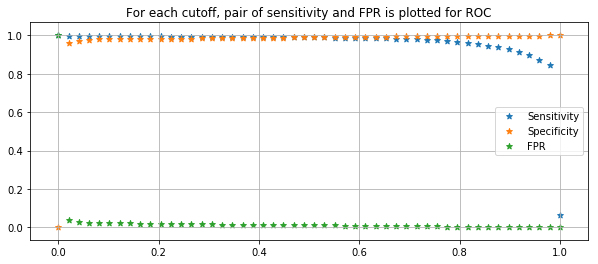

In [309]:
# Plotting specificity and Sensitivity 
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

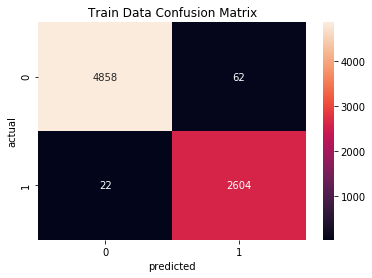

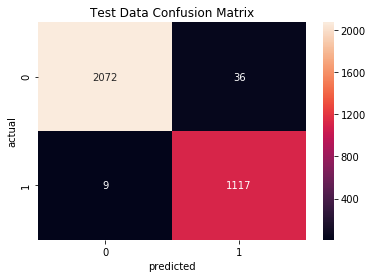

In [311]:
# Confusion Matrix when sensitivity and specificivity are maximum  
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.408 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.408 else 0)
sn.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sn.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()
# (117+236)/(117+236+120+17)

In [312]:
# Accuracy in the training and testing data 
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.9888682745825603
The overall accuracy score for the Test Data  is :  0.9860853432282004


# Accuracy in the training and testing data is almost same and with high in magnitude so the model is not underfitting or overfitting. 
